In [1]:
import skvideo.io
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle
import xgboost as xgb
import os
import time
from tqdm import tqdm
import cv2
color = sns.color_palette()

%matplotlib inline

/kaggle/dev/ashish/car-speed-challenge-2017/speed/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
DATA_PATH = '/kaggle/dev/speed-challenge-2017-data/data'
TRAIN_LABELS = os.path.join(DATA_PATH, 'train.txt')
PREPROCESSED_DATA_PATH = '/kaggle/dev/speed-challenge-2017-data/pre_processed_data'
PREPROCESSED_IMGS_TRAIN = os.path.join(PREPROCESSED_DATA_PATH, 'train_imgs')
PREPROCESSED_IMGS_TEST = os.path.join(PREPROCESSED_DATA_PATH, 'test_imgs')
TRAIN_META = os.path.join(PREPROCESSED_DATA_PATH, 'train_meta.csv')
TEST_META = os.path.join(PREPROCESSED_DATA_PATH, 'test_meta.csv')

In [3]:
train_y = pd.read_csv(TRAIN_LABELS, header=None, squeeze=True)
train_y.head()

0    28.105569
1    28.105569
2    28.106527
3    28.130404
4    28.109243
Name: 0, dtype: float64

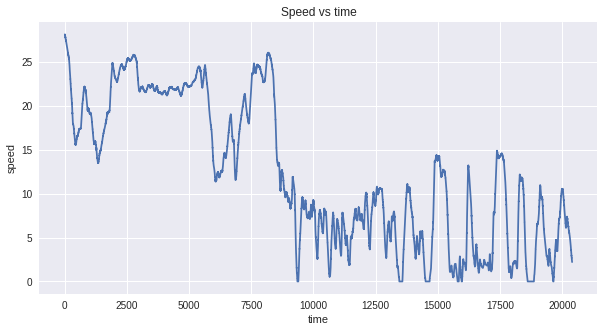

In [4]:
plt.figure(figsize=(10,5))
plt.title('Speed vs time')
plt.ylabel('speed')
plt.xlabel('time')
plt.plot(train_y.index.values, train_y.values)

In [5]:
train_df = pd.read_csv(TRAIN_META)
test_df = pd.read_csv(TEST_META)

In [6]:
train_df.head()

,img_path,img_index,speed
0,/kaggle/dev/speed-challenge-2017-data/pre_proc...,0,28.105569
1,/kaggle/dev/speed-challenge-2017-data/pre_proc...,1,28.105569
2,/kaggle/dev/speed-challenge-2017-data/pre_proc...,2,28.106527
3,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3,28.130404
4,/kaggle/dev/speed-challenge-2017-data/pre_proc...,4,28.109243


In [7]:
test_df.head()

,img_path,img_index,speed
0,/kaggle/dev/speed-challenge-2017-data/pre_proc...,0,NaN
1,/kaggle/dev/speed-challenge-2017-data/pre_proc...,1,NaN
2,/kaggle/dev/speed-challenge-2017-data/pre_proc...,2,NaN
3,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3,NaN
4,/kaggle/dev/speed-challenge-2017-data/pre_proc...,4,NaN


In [8]:
def batch_shuffle(df):
    """
    Randomly shuffle pairs of rows in the dataframe, separates train and validation data
    generates a uniform random variable 0->9, gives 20% chance to append to valid data, otherwise train_data
    return tuple (train_data, valid_data) dataframes
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(df) - 1):
        idx1 = np.random.randint(len(df) - 1)
        idx2 = idx1 + 1
        
        row1 = df.iloc[[idx1]].reset_index()
        row2 = df.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [9]:
train_data, valid_data = batch_shuffle(train_df)

In [10]:
train_data.head()

,index,img_path,img_index,speed
0,5183,/kaggle/dev/speed-challenge-2017-data/pre_proc...,5183,22.768684
0,5184,/kaggle/dev/speed-challenge-2017-data/pre_proc...,5184,22.791706
0,3813,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3813,21.507325
0,3814,/kaggle/dev/speed-challenge-2017-data/pre_proc...,3814,21.504548
0,19956,/kaggle/dev/speed-challenge-2017-data/pre_proc...,19956,9.704993


In [11]:
valid_data.head()

,index,img_path,img_index,speed
0,10893,/kaggle/dev/speed-challenge-2017-data/pre_proc...,10893,3.803614
0,10894,/kaggle/dev/speed-challenge-2017-data/pre_proc...,10894,3.825247
0,19868,/kaggle/dev/speed-challenge-2017-data/pre_proc...,19868,6.857586
0,19869,/kaggle/dev/speed-challenge-2017-data/pre_proc...,19869,6.903299
0,11455,/kaggle/dev/speed-challenge-2017-data/pre_proc...,11455,2.014803


In [12]:
print('valid_data: ', len(valid_data))
print('train_data: ', len(train_data))

valid_data:  8956
train_data:  31842


In [13]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [14]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current,
                                        gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)                                   

    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb_flow

In [15]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    image_cropped = image[100:440, :-90] # -> (380, 550, 3)
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [16]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

CV2 default img (BGR) (480, 640, 3)


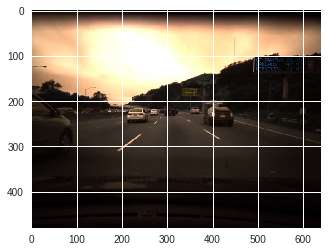

RGB img (480, 640, 3)


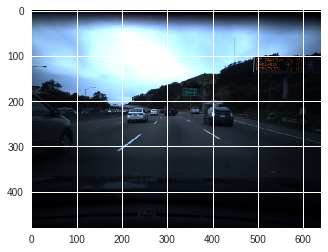

Change brightness img (480, 640, 3)


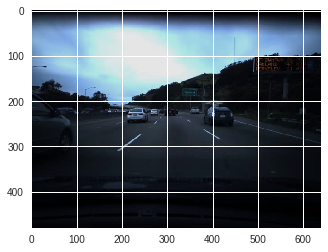

Resized img (66, 220, 3)


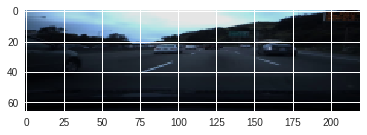

In [51]:
# Example image preprocessing
temp_bright_factor = 0.2 + np.random.uniform()
temp_img = cv2.imread('/kaggle/dev/speed-challenge-2017-data/pre_processed_data/train_imgs/5183.jpg')
print('CV2 default img (BGR)', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
print('RGB img', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = change_brightness(temp_img, temp_bright_factor)
print('Change brightness img', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = preprocess_image(temp_img)
print('Resized img', temp_img.shape)
plt.imshow(temp_img)
plt.show()

In [18]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['img_index'].values[0]
            time_prev = row_prev['img_index'].values[0]
            time_next = row_next['img_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(row1['img_path'].values[0],
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['img_path'].values[0], 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        #print('image_batch', image_batch.shape, ' label_batch', label_batch)
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [19]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            
            time_now = row_now['img_index'].values[0]
            time_prev = row_prev['img_index'].values[0]
            time_next = row_next['img_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(row1['img_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['img_path'].values[0], row2['speed'].values[0])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            #print('img_diff', img_diff.shape, ' speed', speed)
            yield img_diff, speed

In [20]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
import keras.backend.tensorflow_backend as KTF

N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization    
    # perform custom normalization before lambda layer in network
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

Using TensorFlow backend.


In [21]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH_SIZE = 16
print('val_size: ', val_size)

val_size:  8956


In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
ts = str(int(time.time()))
filepath = 'model-weights-{}.h5'.format(ts)

earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=1, 
                              verbose=1, 
                              min_delta = 0.23,
                              mode='min',)
modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                 save_weights_only = True)
callbacks_list = [modelCheckpoint, earlyStopping]

In [26]:
import h5py
model = nvidia_model()
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, BATCH_SIZE)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 25,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

print(history)

Epoch 1/25
400/400 [==============================] - 284s - loss: 46.8800 - val_loss: 24.8522
Epoch 2/25
400/400 [==============================] - 279s - loss: 27.0599 - val_loss: 19.7036
Epoch 3/25
400/400 [==============================] - 278s - loss: 20.3903 - val_loss: 15.2539
Epoch 4/25
400/400 [==============================] - 279s - loss: 16.8465 - val_loss: 12.4065
Epoch 5/25
400/400 [==============================] - 278s - loss: 14.9916 - val_loss: 12.2821
Epoch 6/25
400/400 [==============================] - 277s - loss: 13.1689 - val_loss: 10.1767
Epoch 7/25
400/400 [==============================] - 278s - loss: 12.1382 - val_loss: 10.3355
Epoch 8/25
400/400 [==============================] - 278s - loss: 11.2140 - val_loss: 8.3297
Epoch 9/25
400/400 [==============================] - 278s - loss: 9.9035 - val_loss: 7.2305
Epoch 10/25
400/400 [==============================] - 303s - loss: 9.1829 - val_loss: 7.5023
Epoch 11/25
400/400 [==============================] -